# Generate Water Body Polygons

**What does this notebook do?** This notebook uses output `NetCDF` files of WOFS summaries from `datacube-stats` to generate polygons of water bodies in the landscape. This code follows the following workflow:
* Generate a list of netCDF files within a specified folder location
* Opens each netCDF file and:
    * Keep only pixels observed at least x times
    * Keep only pixels identified as wet at least x% of the time
    * Convert the raster data into polygons
* Append the polygon set to a shapefile
* Remove artificial polygon borders created at tile boundaries by merging polygons that intersect across Albers Tile boundaries
* Filter the combined polygon dataset (note that this step happens after the merging of Albers tile boundary polygons to ensure that artifacts are not created by part of a polygon being filtered out, while the remainder of the polygon that sits on a separate tile is treated differently).
    * Filter the polygons based on size
    * Remove polygons that intersect with Australia's coastline and estuaries
    * Remove erroneous 'water' polygons within high-rise CBD areas
    * Optional filtering for proximity to major rivers (as identified by the Geofabric dataset)
* Save out the final polygon set to a shapefile

**Required inputs:** 
* NetCDF files with WOfS outputs that will be used to define the persistent water body polygons
    * Variable name: `TileFolder`
    * This folder can be either a custom extraction of datacube-stats (as was done here), or you can choose to use the WOfS summary tiles for all of Australia (see [below for further information](#Tiles)).
* A coastline polygon to filter out polygons generated from ocean pixels.
    * Variable name: `LandSeaMaskFile`
    * Here we use the [GEODATA COAST 100K 2004 dataset](https://data.gov.au/dataset/geodata-coast-100k-2004)
* Estuary data layer to supplement the coastline polygon, which does not identify estuaries as 'ocean'
    * Variable name: `EstuariesFile`
    * Here we generated this layer from the [OzCoasts Geomorphic habitat datasets](http://www.ozcoasts.gov.au/search_data/datasets.jsp). Each of the state datasets were downloaded, and only `channel` and `Central Basin` features were retained. These correspond to the locations of open water (including large river channels) within estuary systems (see [below for further information](#Estuaries)).
* Urban high rise polygon dataset
    * Variable name: `UrbanMaskFile`
    * WOfS has a known limitation, where deep shadows thrown by tall CBD buildings are misclassified as water. This means that our algorithm is defining 'water bodies' around these misclassified shadows in capital cities. [See below](#Urban) for a discussion of how an urban mask is produced. 
    
**Optional inputs**
* River line dataset for filtering out polygons comprised of river segments.
    * Variable name: `MajorRiversDataset`
    * The option to filter out major rivers is provided, and so this dataset is optional if `FilterOutRivers = False`.
    * Here we use the [Bureau of Meteorology's Geofabric v 3.0.5 Beta (Suface Hydrology Network)](ftp://ftp.bom.gov.au/anon/home/geofabric/), filtered to only keep features tagged as `major rivers`. 
    * There are some identified issues with this data layer that make the filtering using this data inconsistent (see [the discussion below](#rivers))
    * We therefore turn this off during the production of the water bodies shapefile. 
    

**Code history**

This notebook is an updated version of `FindLotsOfDamsUsingWOFLsInaLoop.ipynb`. This copy was created to maintain the prototype workflow, while updating the operational workflow for water body polygon production.

**Date:** May 2019

**Author:** Claire Krause

**Quality Check Performed, March 2019:** Imam Alam, Alex Vincent, Bex Dunn, Damien Ayers

**DEA module and environment version used**: `/dea-env/20190329`, `/dea/20190329` (See the accompanying [GenerateWaterBodyPolygonsRequirements.txt](files/GenerateWaterBodyPolygonsRequirements.txt) for a complete list of python libraries loaded into the environment).

## Water Observations from Space inputs

The Waterbody Area Mapping and Monitoring (WAMM) service provides insights into both the location and dynamics of water bodies across Australia. The [Water Observations from Space (WOfS) product](https://www.sciencedirect.com/science/article/pii/S0034425715301929) is used to map the locations of water bodies across Australia. The analysis was done on a per pixel basis prior to combining adjoining pixels into polygon objects (i.e. drawing a boundary around them and considering them as a single object rather than a series of individual pixels).  

A [sensitivity analysis](WAMMSensitivityAnalysis.ipynb) was conducted to determine the most suitable analysis date range and wetness thresholds for identifying persistent waterbodies. A compromise was sought between over and under identification of waterbodies, in order to correctly classify waterbodies, while limiting false positives and false negatives. 

**Pixels were included in this analysis, where during the period from 1987 to 2018, pixels were classified as 'wet' using the WOfS product, at least 10% of the time. A secondary threshold of 5% was used to supplement the spatial footprints of polygons identified using the 10% threshold. 
The rationale for these parameters are explored in detail in the [sensitivity analysis](WAMMSensitivityAnalysis.ipynb), but are summarised below:**

### Analysis date range

All available observations were included within this analysis (1987 to 2018), with the exception of the most recent months, which were excluded to end the analysis at the end of 2018. During the analysis period, three Landsat satellites were active: Landsat 5 (2000 - 2010), Landsat 7 (2000 - present), and Landsat 8 (2013 - present). Each satellite has a return period of ~16 days. 

Over the 31 year analysis period, across the three satellite platforms, each pixel across Australia was observed clearly, and classified approximately 420 times (average; min = 2, max = 1328, standard deviation = 195). Differences in the number of times each pixel was observed was caused by clouds (which meant the observation was not used), 

<a id='wetness'></a>
### Wetness threshold



### Results 

The WOfS statistics return three results within each NetCDF file:
- count_wet: Number of times a pixel was validly observed as wet.
- count_clear: Number of times a pixel was validly observed (wet + dry)
- frequency: Frequency of a wet observation (wet / clear)

The NetCDF files each contain one Australian Albers tile of data, allowing us to split up the analysis on a tile-by-tile basis, prior to combining the data across the whole study region.

In [2]:
%pylab notebook

import rasterio.features
from shapely.geometry import Polygon, shape, mapping
from shapely.ops import unary_union
import geopandas as gp
import fiona
from fiona.crs import from_epsg
import xarray as xr
import pandas as pd
import glob
import os.path
import math

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Polygon', 'shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Set up the functions for this script

In [3]:
def Generate_list_of_albers_tiles(TileFolder = 'TileFolder'):
    '''
    Generate a list of Albers tiles to loop through for the water body analysis. This 
    function assumes that the list of tiles will be generated from a custom 
    datacube-stats run, and the file names will have the format
    
    */wofs_summary_8_-37_{date}.nc
    
    The tile number is expected in the 2nd and 3rd last positions when the string has been
    broken using `_`. If this is not the case, then this code will not work, and will throw an error. 
    
    Parameters
    ----------
    
    TileFolder : str
        This is the path to the folder of netCDF files for analysis. If this is not provided, or an
        incorrect path name is provided, the code will exit with an error.
    
    Returns
    -------
    CustomRegionAlbersTiles: list
        List of Albers tiles across the analysis region. 
        E.g. ['8_-32', '9_-32', '10_-32', '8_-33', '9_-33']
    
    '''  
    if os.path.exists(TileFolder) == False:
        print('** ERROR ** \n'
            'You need to specify a folder of files for running a custom region')
        return
    
    # Grab a list of all of the netCDF files in the custom folder
    TileFiles = glob.glob(f'{TileFolder}*.nc')

    CustomRegionAlbersTiles = set()
    for filePath in TileFiles:
        AlbersTiles = filePath.split('_')
        
        # Test that the albers tile numbers are actually where we expect them to be in the file name
        try: 
            int(AlbersTiles[-3])
            int(AlbersTiles[-2])
        except ValueError:
            print('** ERROR ** \n'
                'The netCDF files are expected to have the file format "*/wofs_summary_8_-37_{date}.nc",\n'
                'with the Albers tile numbers in the 2nd and 3rd last positions when separated on `_`. \n'
                'Please fix the file names, or alter the `Generate_list_of_albers_tiles` function.')
            return

        # Now that we're happy that the file is reading the correct Albers tiles
        ThisTile = f'{AlbersTiles[-3]}_{AlbersTiles[-2]}'
        CustomRegionAlbersTiles.add(ThisTile)
    CustomRegionAlbersTiles = list(CustomRegionAlbersTiles)
    return CustomRegionAlbersTiles

def Generate_list_of_tile_datasets(ListofAlbersTiles, Year, TileFolder = 'TileFolder', CustomData = True):
    '''
    Generate a list of Albers tiles datasets to loop through for the water body analysis. 
    
    Parameters
    ----------
    
    CustomRegionAlbersTiles: list
        List of albers tiles to loop through
        E.g. ['8_-32', '9_-32', '10_-32', '8_-33', '9_-33']
    Year: int
        Year for the analysis. This will correspond to the netCDF files for analysis.
    TileFolder : str
        This is the path to the folder of netCDF files for analysis. If this is not provided, or an
        incorrect path name is provided, the code will exit with an error.
    
    Returns
    -------
    Alltilespaths: list
        List of file paths to files to be analysed.
    
    '''  
    
    if os.path.exists(TileFolder) == False:
        print('** ERROR ** \n'
            'You need to specify a folder of files for running a custom region')
        raise

    Alltilespaths = []
    
    if CustomData:
        for tile in ListofAlbersTiles:
            Tiles = glob.glob(f'{TileFolder}*_{tile}_{Year}0101.nc')
            Alltilespaths.append(Tiles[0]) # Assumes only one file will be returned
    else:
        for tile in ListofAlbersTiles:
            Tiles = glob.glob(f'{TileFolder}wofs_filtered_summary_{tile}.nc')
            Alltilespaths.append(Tiles[0]) # Assumes only one file will be returned
 
    return Alltilespaths

def Filter_shapefile_by_intersection(gpdData, gpdFilter, filtertype = 'intersects', invertMask = True, 
                                     returnInverse = False):
    '''
    Filter out polygons that intersect with another polygon shapefile. 
    
    Parameters
    ----------
    
    gpdData: geopandas dataframe
        Polygon data that you wish to filter
    gpdFilter: geopandas dataframe
        Dataset you are using as a filter
    
    Optional
    --------
    filtertype: default = 'intersects'
        Options = ['intersects', 'contains', 'within']
    invertMask: boolean
        Default = 'True'. This determines whether you want areas that DO ( = 'False') or DON'T ( = 'True')
        intersect with the filter shapefile.
    returnInnverse: boolean
        Default = 'False'. If true, then return both parts of the intersection - those that intersect AND 
        those that don't as two dataframes.
    
    Returns
    -------
    gpdDataFiltered: geopandas dataframe
        Filtered polygon set, with polygons that intersect with gpdFilter removed.
    IntersectIndex: list of indices of gpdData that intersect with gpdFilter
    
    Optional
    --------
    if 'returnInverse = True'
    gpdDataFiltered, gpdDataInverse: two geopandas dataframes
        Filtered polygon set, with polygons that DON'T intersect with gpdFilter removed.
    '''    
    
    # Check that the coordinate reference systems of both dataframes are the same
    
    #assert gpdData.crs == gpdFilter.crs, 'Make sure the the coordinate reference systems of the two provided dataframes are the same'
    
    Intersections = gp.sjoin(gpdFilter, gpdData, how="inner", op=filtertype)
    
    # Find the index of all the polygons that intersect with the filter
    IntersectIndex = sorted(set(Intersections['index_right']))
    
    # Grab only the polygons NOT in the IntersectIndex
    # i.e. that don't intersect with a river
    if invertMask:
        gpdDataFiltered = gpdData.loc[~gpdData.index.isin(IntersectIndex)]
    else:
        gpdDataFiltered = gpdData.loc[gpdData.index.isin(IntersectIndex)]
    
    if returnInverse:
        # We need to use the indices from IntersectIndex to find the inverse dataset, so we
        # will just swap the '~'.
        
        if invertMask:
            gpdDataInverse = gpdData.loc[gpdData.index.isin(IntersectIndex)]
        else:
            gpdDataInverse = gpdData.loc[~gpdData.index.isin(IntersectIndex)]
            
        return gpdDataFiltered, IntersectIndex, gpdDataInverse
    else:    
        
        return gpdDataFiltered, IntersectIndex

## Set up all the parameters for the script

<a id='valid'></a>
### Filter results based on number of valid observations

The number of valid WOfS observations for each pixel varies depending on the frequency of clouds and cloud shadow, and the proximity to high slope and terrain shadow, and the seasonal change in solar angle. 

The `count_clear` parameter provides a count of the number of valid observations each pixel recorded over the analysis period. We can use this parameter to mask out pixels that were infrequently observed. If this mask is not applied, pixels that were observed only once could be included, if that observation was wet (i.e. a single wet observation means the calculation of the frequency statistic would be (1 wet observation) / (1 total observation) = 100% frequency of wet observations).

Here we set the minimum number of observations to be ~2 per year. For our 32 year analysis, this means the minimum number of valid observations is 76.

In [4]:
MinimumValidObs = 76

<a id='wetnessThreshold'></a>
### How wet does a pixel need to be to be included?
The value/s set here will be the minimum amount of time (as a decimal between 0 and 1) that you want water to be detected before it is included in the analysis. 

E.g. If this was set to 0.10, any pixels that are wet *at least* 10% of the time will be included. If you don't want to use this filter, set this value to 0.

Following the exploration of an appropriate wetness threshold for our purposes ([see above](#wetness)), we choose to set two thresholds here. The code is set up to loop through both wetness thresholds, and to write out two temporary shapefiles. These two shapefiles with two separate thresholds are then used together to combine polygons from both thresholds later on in the workflow.

Polygons identified by the secondary threshold that intersect with the polygons generated by the primary threshold will be extracted, and included in the final polygon dataset. This means that the **location** of polygons is set by the primary threshold, but the **shape** of these polygons is set by the secondary threshold.

Threshold values need to be provided as a list of either one or two floating point numbers. If one number is provided, then this will be used to generate the initial polygon dataset. If two thresholds are entered, the **first number becomes the secondary threshold, and the second number becomes the primary threshold**. If more than two numbers are entered, the code will generate an error below. 

In [5]:
AtLeastThisWet = [0.05, 0.10]

<a id='size'></a>
### How big/small should the polygons be?
This filtering step can remove very small and/or very large polygons. The size listed here is in m2. A single pixel in Landsat data is 25 m X 25 m = 625 m2. 

**MinSize**

E.g. A minimum size of 6250 means that polygons need to be at least 10 pixels to be included. If you don't want to use this filter, set this value to 0.

**MaxSize**

E.g. A maximum size of 1 000 000 means that you only want to consider polygons less than 1 km2. If you don't want to use this filter, set this number to `math.inf`.

In [6]:
MinSize = 3120 # 5 pixels
MaxSize = math.inf # No upper limit

<a id='rivers'></a>
### Do you want to filter out polygons that intersect with major rivers?

**Note that for the Water Body Polygon dataset, we set this filter to False (`FilterOutRivers = False`). The code has been kept here in case it's of use for further filtering of the results later on.**

We use the [Bureau of Meteorology's Geofabric v 3.0.5 Beta (Suface Hydrology Network)](ftp://ftp.bom.gov.au/anon/home/geofabric/) to filter out polygons that intersect with major rivers. This is done to remove river segments from the polygon dataset. We use the `SH_Network AHGFNetworkStream any` layer within the `SH_Network_GDB_V2_1_1.zip` geodatabase, and filter the dataset to only keep rivers tagged as `major`. It is this filtered dataset we use here.

Note that we reproject this dataset to `epsg 3577`, Australian Albers coordinate reference system. If this is not correct for your analysis, you can change this in the cell below.

If you don't want to filter out polygons that intersect with rivers, set this parameter to `False`.

#### Note when using the Geofabric to filter out rivers

The option to filter out rivers was switched off for the production of our water bodies dataset. During testing, the Geofabric dataset was shown to lead to inconsistencies in what was removed, and what remained within the dataset. 

* The Geofabric continues the streamline through on-river dams, which means these polygons are filtered out. This may not be the desired result. 

![Stream and Dam intersection](OnRiverDam.JPG "An in-river dam that would be removed by the river filter, but may not be the desired result")

In [7]:
FilterOutRivers = False

In [8]:
# Where is this file located?
MajorRiversDataset = '/g/data/r78/cek156/ShapeFiles/Geofabric_v2_1_1/SH_Network_GDB_V2_1_1_Major_Filtered.shp'

# Read in the major rivers dataset (if you are using it)
if FilterOutRivers:
    MajorRivers = gp.GeoDataFrame.from_file(MajorRiversDataset) 
    MajorRivers = MajorRivers.to_crs({'init':'epsg:3577'})

<a id='Tiles'></a>
### Set up the input datasets for the analysis

In [9]:
AllOfAustraliaAllTime = False

CustomData = True
AutoGenerateTileList = True

If you would like to perform the analysis for all of Australia, using the published WOfS all time summaries, set `AllofAustraliaAllTime = True`. 
(*Note there is a bug with this option at the moment - the all time summaries have different variable names than the datacube stats outputs, so this needs to be fixed*)

If `CustomData = True`, you will need to specify the location of the data you would like to use for this analysis, setting `TileFolder` below, under the `if CustomData` code section below.  

If `CustomData = False`, the code will automatically look at the published WOfS all time summaries. (*Note there is a bug with this option at the moment - the all time summaries have different variable names than the datacube stats outputs, so this needs to be fixed*)

If you would like to automatically generate a list of tiles using the outputs of an analysis (e.g. we have previously run a custom `datacube-stats` analysis using this region, and so we can generate a list of tiles that we know covers this area using the outputs of this analysis), set `AutoGenerateTileList = True` and update the location of the output file directory.

If you would like to manually feed in a list of albers tiles, set `AutoGenerateTileList = False`, and feed in a list of tiles in the format:

```
ListofAlbersTiles = ['7_-34', '10_-40', '16_-34']
```
<br/>    
**NOTE** For testing and debugging, set `CustomData = True` and `AutoGenerateTileList = False`, then enter a list of tiles to run using the `ListofAlbersTiles` described above.

In [10]:
if CustomData:
    TileFolder = '/g/data/r78/cek156/datacube_stats/WOFSDamsAllTimeNSWMDB/'
else:
    TileFolder = '/g/data/fk4/datacube/002/WOfS/WOfS_Filt_Stats_25_2_1/netcdf/'

In [11]:
if AutoGenerateTileList:
    ListofAlbersTiles = Generate_list_of_albers_tiles(TileFolder)
else:
    ListofAlbersTiles = ['19_-40', '8_-32', '10_-30', '14_-31', '13_-31', '18_-38', '19_-33', '9_-31', '20_-34', 
                         '6_-39', '17_-31', '12_-40', '13_-39', '10_-38', '6_-41', '16_-32', '9_-40', '10_-31', 
                         '16_-37', '10_-39', '16_-35', '7_-38', '10_-37', '17_-39', '9_-34', '19_-35', '15_-33', 
                         '15_-30', '11_-32', '20_-39', '17_-30', '13_-40', '7_-41', '17_-29', '12_-33', '15_-28',
                         '16_-40', '6_-35', '17_-40', '13_-38', '17_-42', '14_-39', '13_-29', '17_-37', '16_-38',
                         '9_-32', '16_-34', '9_-41', '11_-31', '7_-36', '16_-39', '18_-30', '9_-37', '20_-37',
                         '13_-32', '7_-40', '18_-41', '20_-32', '8_-41', '14_-28', '18_-39', '14_-43', '12_-39',
                         '20_-36', '8_-34', '17_-41', '12_-41', '18_-31', '11_-38', '18_-34', '14_-35', '12_-42',
                         '19_-39', '12_-34', '10_-42', '11_-35', '17_-35', '15_-41', '18_-33', '6_-37', '13_-41',
                         '10_-40', '14_-33', '13_-37', '8_-36', '6_-36', '16_-43', '18_-36', '14_-40', '15_-43',
                         '12_-30', '5_-39', '8_-39', '18_-35', '15_-39', '15_-29', '7_-34', '11_-34', '14_-41',
                         '15_-42', '16_-29', '16_-28', '14_-37', '8_-33', '6_-38', '19_-38', '13_-33', '16_-36',
                         '15_-37', '12_-38', '7_-35', '18_-40', '12_-31', '16_-41', '14_-38', '19_-37', '10_-34',
                         '14_-32', '12_-32', '14_-42', '15_-35', '16_-31', '19_-36', '7_-37', '11_-41', '14_-36',
                         '13_-35', '16_-42', '13_-36', '6_-40', '17_-36', '10_-41', '18_-37', '14_-29', '14_-30',
                         '20_-38', '17_-38', '12_-36', '10_-35', '9_-42', '21_-33', '12_-37', '17_-32', '15_-31',
                         '10_-36', '15_-36', '19_-34', '17_-34', '12_-35', '20_-40', '20_-33', '19_-31', '20_-35',
                         '16_-30', '18_-32', '12_-29', '11_-30', '15_-32', '16_-33', '8_-37', '10_-33', '13_-34', 
                         '11_-33', '13_-30', '11_-36', '8_-40', '11_-40', '10_-32', '9_-38', '11_-42', '11_-39',
                         '15_-34', '21_-34', '13_-42', '9_-35', '8_-42', '17_-33', '8_-38', '13_-28', '15_-38',
                         '9_-36', '8_-35', '11_-37', '14_-34', '15_-40', '9_-33', '19_-32', '9_-39', '7_-39']

<a id='coastline'></a>
### Set up a land/sea mask

Use the [GEODATA COAST 100K 2004 dataset](https://data.gov.au/dataset/geodata-coast-100k-2004) as a coarse approximation of the mean high water coastline to remove ocean from water layers

<IPython.core.display.Javascript object>


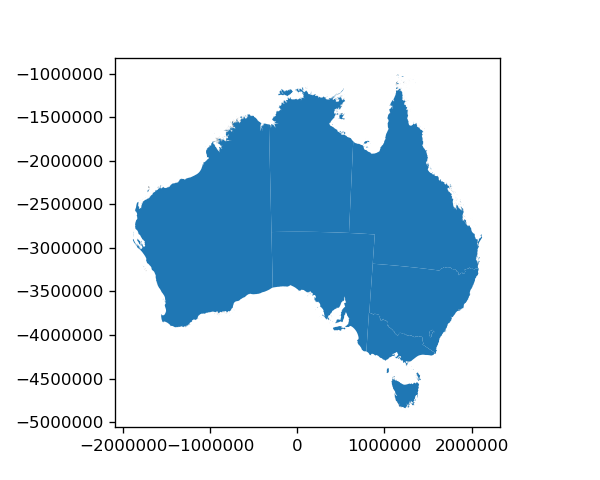

In [4]:
LandSeaMaskFile = '/g/data/r78/rt1527/datasets/Coastlines/australia/cstauscd_r.shp'

Coastline = gp.read_file(LandSeaMaskFile)
Coastline = Coastline.to_crs({'init': 'epsg:3577'})
Coastline = Coastline[(Coastline.FEAT_CODE == 'island') | (Coastline.FEAT_CODE == 'mainland')]
Coastline.plot(figsize=(5, 4))

<a id='Estuaries'></a>

### Estuaries need to be handled separately

An estuary data layer was generated from the [OzCoasts Geomorphic habitat datasets](http://www.ozcoasts.gov.au/search_data/datasets.jsp). Each of the state datasets were downloaded, and only `channel` and `Central Basin` features were retained. These correspond to the locations of open water (including large river channels) within estuary systems.

In [5]:
EstuariesFile = '/g/data/r78/cek156/ShapeFiles/OzCoastsCoastalWaterwaysGeomorphicHabitatMapping/Aus_geohab_av.shp'

Estuaries = gp.read_file(EstuariesFile)
Estuaries = Estuaries.to_crs({'init': 'epsg:3577'})

<a id='Urban'></a>

### Read in a mask for high-rise CBDs

WOfS has a known limitation, where deep shadows thrown by tall CBD buildings are misclassified as water. This means that our algorithm is defining 'water bodies' around these misclassified shadows in capital cities. 

To address this problem, we use the [Australian Bureau of Statistics Statistical Area 3 shapefile (2016)](http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.001July%202016?OpenDocument#Data) to define a spatial footprint for Australia's CBD areas. 

We use the following polygons as our CBD filter:

|SA3_CODE1|SA3_NAME16|
|---------|----------|
|11703    |Sydney Inner City|
|20604    |Melbourne City|
|30501    |Brisbane Inner|
|30901    |Broadbeach - Burleigh|
|30910    |Surfers Paradise|
|40101    |Adelaide City|
|50302    |Perth City|

In [8]:
UrbanMaskFile = '/g/data/r78/cek156/ShapeFiles/ABS_1270055001_sa3_2016_aust_shape/HighRiseCBD_ABS_sa3.shp'

CBDs = gp.read_file(UrbanMaskFile)
CBDs = CBDs.to_crs({'init': 'epsg:3577'})

## Generate the first temporary polygon dataset

This code section:

1. Checks that the `AtLeastThisWet` threshold has been correctly entered above
2. Sets up a `for` loop that allows the user to input multiple temporal datasets (see below)
3. Generates a list of netCDF files to loop through
4. Sets up a `for` loop for that list of files. Here we have separate data for each Landsat tile, so this loop loops through the list of tile files
5. Opens the netCDF `frequency` data and removes the `time` dimension (which in this case is only of size 1)
6. Opens the netCDF `count_clear` data and removes the `time` dimension (which in this case is only of size 1)
7. Removes any pixels not observed at least [`MinimumValidObs` times](#valid)
8. Sets up a `for` loop for the entered [`AtLeastThisWet` thresholds](#wetnessThreshold)
9. Masks out any data that does not meet the wetness threshold
10. Converts the data to a Boolean array, with included pixels == 1
11. Converts the raster array to a polygon dataset
12. Cleans up the polygon dataset
13. Resets the `geometry` to a shapely geometry
14. Merges any overlapping polygons
15. Convert the output of the merging back into a geopandas dataframe
16. Calculates the area of each polygon
17. Saves the results to a shapefile

Within this section you need to set up:
- **WaterBodiesShp:** The name and filepath of the intermediate output polygon set
- **WOFSshpMerged:** The name and filepath of the final corrected output polygon set
- **years to analyse:** `for year in range(x,y)` - note that the last year is NOT included in the analysis. This for loop is set up to allow you to loop through multiple datasets to create multiple polygon outputs. If you only have one input dataset, set this to `range(<year of the analysis>, <year of the analysis + 1>)`

In [ ]:
## Set up some file names for the inputs and outputs
# The name and filepath of the intermediate output polygon set
WaterBodiesShp = f'/g/data/r78/cek156/dea-notebooks/WaterbodyAreaMappingandMonitoring/MDBANSWAllTime01-005HybridWaterbodies/Temp'

# The name and filepath of the final corrected output polygon set
WOFSshpMerged = f'/g/data/r78/cek156/dea-notebooks/WaterbodyAreaMappingandMonitoring/MDBANSWAllTime01-005HybridWaterbodies/NSWMDBWaterBodies.shp'

# First, test whether the wetness threshold has been correctly set
if len(AtLeastThisWet) == 2:
    print(f'We will be running a hybrid wetness threshold. Please ensure that the major threshold is \n'
          f'listed second, with the supplementary threshold entered first.' 
          f'**You have set {AtLeastThisWet[-1]} as the primary threshold,** \n'
          f'**with {AtLeastThisWet[0]} set as the supplementary threshold.**')
elif len(AtLeastThisWet) == 1:
    print(f'You have not set up the hybrid threshold option. If you meant to use this option, please \n'
         f'set this option by including two wetness thresholds in the `AtLeastThisWet` variable above. \n'
         f'The wetness threshold we will use is {AtLeastThisWet}.')
else:
    raise ValueError (f'There is something wrong with your entered wetness threshold. Please enter a list \n'
                      f'of either one or two numbers. You have entered {AtLeastThisWet}. \n'
                      f'See above for more information')

# Now perform the analysis to generate the first iteration of polygons
for year in range(1980,1981):
    
    ### Get the list of netcdf file names to loop through
    if AllOfAustraliaAllTime:
        # Grab everything from the published WOfS all time summaries
        Alltiles = glob.glob(f'{TileFolder}/')
    else:
        Alltiles = Generate_list_of_tile_datasets(ListofAlbersTiles, year, TileFolder, CustomData)            
        
    for WOFSfile in Alltiles: 
        try:
            # Read in the data
            # Note that the netCDF files we are using here contain a variable called 'frequency',
            # which is what we are using to define our water polygons.
            # If you use a different netCDF input source, you may need to change this variable name here
            WOFSnetCDFData = xr.open_rasterio(f'NETCDF:{WOFSfile}:frequency')
            # Remove the superfluous time dimension
            WOFSnetCDFData = WOFSnetCDFData.squeeze()
            
            # Open the clear count variable to generate the minimum observation mask
            WOFSvalidcount = xr.open_rasterio(f'NETCDF:{WOFSfile}:count_clear')
            WOFSvalidcount = WOFSvalidcount.squeeze()

            # Filter our WOfS classified data layer to remove noise
            # Remove any pixels not abserved at least MinimumValidObs times
            WOFSValidFiltered = WOFSvalidcount >= MinimumValidObs
            
            for Thresholds in AtLeastThisWet:
                # Remove any pixels that are wet < AtLeastThisWet% of the time
                WOFSfiltered = WOFSnetCDFData > Thresholds

                # Now find pixels that meet both the MinimumValidObs and AtLeastThisWet criteria
                # Change all zeros to NaN to create a nan/1 mask layer
                # Pixels == 1 now represent our water bodies
                WOFSfiltered = WOFSfiltered.where((WOFSfiltered !=0) & (WOFSValidFiltered !=0))

                # Convert the raster to polygons
                # We use a mask of '1' to only generate polygons around values of '1' (not NaNs)
                WOFSpolygons = rasterio.features.shapes(WOFSfiltered.data.astype('float32'), 
                                                        mask = WOFSfiltered.data.astype('float32') == 1,
                                                        transform = WOFSnetCDFData.transform)
                # The rasterio.features.shapes returns a tuple. We only want to keep the geometry portion,
                # not the value of each polygon (which here is just 1 for everything)
                WOFSbreaktuple = (a for a, b in WOFSpolygons)

                # Put our polygons into a geopandas geodataframe
                PolygonGP = gp.GeoDataFrame(list(WOFSbreaktuple))

                # Grab the geometries and convert into a shapely geometry
                # so we can quickly calcuate the area of each polygon
                PolygonGP['geometry'] = None
                for ix, poly in PolygonGP.iterrows():
                    poly['geometry'] = shape(poly)

                # Set the geometry of the dataframe to be the shapely geometry we just created    
                PolygonGP = PolygonGP.set_geometry('geometry')
                # We need to add the crs back onto the dataframe
                PolygonGP.crs = {'init': 'epsg:3577'}

                # Combine any overlapping polygons
                MergedPolygonsGeoms = unary_union(PolygonGP['geometry'])

                # Turn the combined multipolygon back into a geodataframe
                MergedPolygonsGPD = gp.GeoDataFrame([poly for poly in MergedPolygonsGeoms])
                # Rename the geometry column
                MergedPolygonsGPD.columns = ['geometry']
                # We need to add the crs back onto the dataframe
                MergedPolygonsGPD.crs = {'init': 'epsg:3577'}

                # Calculate the area of each polygon again now that overlapping polygons
                # have been merged
                MergedPolygonsGPD['area'] = MergedPolygonsGPD['geometry'].area

                # Save the polygons to a shapefile
                schema = {'geometry': 'Polygon','properties': {'area': 'str'}}
                
                # Generate our dynamic filename
                FileName = f'{WaterBodiesShp}_{Thresholds}.shp'
                # Append the file name to the list so we can call it later on

                if os.path.isfile(FileName):
                    with fiona.open(FileName, "a", crs = from_epsg(3577), 
                                    driver = 'ESRI Shapefile', schema = schema) as output:
                        for ix, poly in MergedPolygonsGPD.iterrows():
                                        output.write(({'properties': {'area': poly['area']},
                                                       'geometry': mapping(shape(poly['geometry']))})) 
                else:
                    with fiona.open(FileName, "w", crs = from_epsg(3577), 
                                    driver = 'ESRI Shapefile', schema = schema) as output:
                        for ix, poly in MergedPolygonsGPD.iterrows():
                            output.write(({'properties': {'area': poly['area']},
                                           'geometry': mapping(shape(poly['geometry']))}))

        except:
            print(f'There is something wrong with {WOFSfile}')

We will be running a hybrid wetness threshold. Please ensure that the major threshold is 
listed second, with the supplementary threshold entered first.**You have set 0.1 as the primary threshold,** 
**with 0.05 set as the supplementary threshold.**
There is something wrong with /g/data/r78/cek156/datacube_stats/WOFSDamsAllTimeNSWMDB/wofs_summary_9_-40_19800101.nc
There is something wrong with /g/data/r78/cek156/datacube_stats/WOFSDamsAllTimeNSWMDB/wofs_summary_12_-32_19800101.nc


## Merge polygons that have an edge at a tile boundary

Now that we have all of the polygons across our whole region of interest, we need to check for artifacts in the data caused by tile boundaries. This process is applied to the primary wetness thresholded polygon dataset only. 

We have created a shapefile that consists of the albers tile boundaries, plus a 1 pixel (25 m) buffer. This shapefile will help us to find any polygons that have a boundary at the edge of an albers tile. We can then find where polygons touch across this boundary, and join them up.

Within this section you need to set up:
- **AlbersBuffer:** The file location of a shapefile that is a 1 pixel buffer around the Albers tile boundaries

In [16]:
# Get the names of the temp files created above, that we dynamically created with the thresholds
FileNames = glob.glob(f'{WaterBodiesShp[:-4]}/*.shp')

AlbersBuffer = gp.read_file(
    '/g/data/r78/cek156/ShapeFiles/AlbersBuffer25m.shp')

# We are using the more severe wetness threshold as the main polygon dataset.
# Note that this assumes that the thresholds have been correctly entered into the 'AtLeastThisWet'
# variable, with the higher threshold listed second.
WaterPolygons = gp.read_file(f'{WaterBodiesShp}_{AtLeastThisWet[-1]}.shp')

# Find where the albers polygon overlaps with our dam polygons
BoundaryMergedDams, IntersectIndexes, NotBoundaryDams= Filter_shapefile_by_intersection(WaterPolygons, AlbersBuffer, 
                                                                      invertMask=False, 
                                                                      returnInverse=True)

# Now combine overlapping polygons in `BoundaryDams`
UnionBoundaryDams = BoundaryMergedDams.unary_union

# `Explode` the multipolygon back out into individual polygons
UnionGDF = gp.GeoDataFrame(crs=WaterPolygons.crs, geometry=[UnionBoundaryDams])
MergedDams = UnionGDF.explode()

# Then combine our new merged polygons with the `NotBoundaryDams`
# Combine New merged polygons with the remaining polygons that are not near the tile boundary
AllTogether = gp.GeoDataFrame(pd.concat([NotBoundaryDams, MergedDams],
                                        ignore_index=True, sort=True)).set_geometry('geometry')

# Calculate the area of each polygon
AllTogether['area'] = AllTogether.area

## Filter the merged polygons by:
- **Area:**
Based on the `MinSize` and `MaxSize` parameters set [here](#size).
- **Coastline:**
Using the `Coastline` dataset loaded [here](#coastline).
- **Estuaries:**
Using the `Estuaries` dataset loaded [here](#Estuaries).
- **CBD location:**
Using the `CBDs` dataset loaded [here](#Urban).
- **Wetness thresholds:**
Here we apply the hybrid threshold described [here](#wetness)
- **Intersection with rivers (optional):**
Using the `MajorRivers` dataset loaded [here](#rivers)

In [19]:
# Filter out any polygons smaller than MinSize, and greater than MaxSize
WaterBodiesBig = AllTogether.loc[((AllTogether['area'] > MinSize) & (AllTogether['area'] <= MaxSize))]

# Filter out any ocean in the pixel
WaterBodiesLand, IntersectIndexes = Filter_shapefile_by_intersection(WaterBodiesBig, Coastline, 
                                                   invertMask = False)

# Filter out the estuaries
WaterBodiesNotEstuaries, IntersectIndexes = Filter_shapefile_by_intersection(WaterBodiesLand, Estuaries)

# WOfS has a known bug where deep shadows from high-rise CBD buildings are misclassified
# as water. We will use the ABS sa3 dataset to filter out Brisbane, Gold Coast, Sydney, 
# Melbourne, Adelaide and Perth CBDs. 
NotCities, IntersectIndexes = Filter_shapefile_by_intersection(WaterBodiesNotEstuaries, CBDs)

# Check for hybrid wetness thresholds
if len(AtLeastThisWet) == 2:
    # Note that this assumes that the thresholds have been correctly entered into the 'AtLeastThisWet'
    # variable, with the supplementary threshold listed first.
    WaterPolygons005 = gp.read_file(f'{WaterBodiesShp}_{AtLeastThisWet[0]}.shp')
    # Find where the albers polygon overlaps with our dam polygons
    BoundaryMergedDams, IntersectIndexes = Filter_shapefile_by_intersection(WaterPolygons005,
                                                                            NotCities)
    # Pull out the polygons from the supplementary shapefile that intersect with the primary shapefile
    WaterPolygons005ToUse = WaterPolygons005.loc[WaterPolygons005.index.isin(IntersectIndexes)]
    # Concat the two polygon sets together
    CombinedPolygons = gp.GeoDataFrame(pd.concat([WaterPolygons005ToUse, NotCities], ignore_index=True))
    # Merge overlapping polygons
    CombinedPolygonsUnion = CombinedPolygons.unary_union
    # `Explode` the multipolygon back out into individual polygons
    UnionGDF = gp.GeoDataFrame(crs=WaterPolygons005.crs, geometry=[CombinedPolygonsUnion])
    HybridDams = UnionGDF.explode()
else:
    print('You have not set up the hybrid threshold option. If you meant to use this option, please \n'
          'set this option by including two wetness thresholds in the `AtLeastThisWet` variable above')
    HybridDams = NotCities

# Here is where we do the river filtering (if FilterOutRivers == True)
if FilterOutRivers:
    WaterBodiesBigRiverFiltered, IntersectIndexes = Filter_shapefile_by_intersection(HybridDams, MajorRivers)
else:
    # If river filtering is turned off, then we just keep all the same polygons
    WaterBodiesBigRiverFiltered = HybridDams

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


## Write out the final results to a shapefile

In [20]:
WaterBodiesBigRiverFiltered.crs = {'init': 'epsg:3577'}
WaterBodiesBigRiverFiltered.to_file(WOFSshpMerged, driver='ESRI Shapefile')

In [6]:
WOFSshpMerged = f'/g/data/r78/cek156/dea-notebooks/WaterbodyAreaMappingandMonitoring/MDBANSWAllTime01-005HybridWaterbodies/NSWMDBWaterBodies.shp'

WaterBodiesBig = gp.read_file(WOFSshpMerged)

# Filter out any ocean in the pixel
WaterBodiesLand, IntersectIndexes = Filter_shapefile_by_intersection(WaterBodiesBig, Coastline, 
                                                   invertMask = False)

# Filter out the estuaries
WaterBodiesNotEstuaries, IntersectIndexes = Filter_shapefile_by_intersection(WaterBodiesLand, Estuaries)



In [9]:
NotCities, IntersectIndexes = Filter_shapefile_by_intersection(WaterBodiesNotEstuaries, CBDs)

In [10]:
NotCities.crs = {'init': 'epsg:3577'}
NotCities.to_file(WOFSshpMerged, driver='ESRI Shapefile')